<h1> Imports

In [60]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal
import pywt

<h1> Fitlering Functions

In [61]:
def apply_butterband_filter(input_df):
    df = input_df.copy()
    for col in df.columns:
        df[col] = filter_df_col(df, col)
        
    return df

def filter_df_col(df, col):
    fs = 512.0
    lowcut = 12.0
    highcut = 25.0
    
    vals = df[col].values
    return butter_bandpass_filter(vals, lowcut, highcut, fs)

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = data * 50    # amplify data
    y = filtfilt(b, a, data)
    return y

In [300]:
from joblib import dump, load

def wavelet_dwt(df):
    return pywt.dwt(df.values, 'db5')

def wavelet_dwt(df):
    return pywt.dwt(df, 'db4')

def pca_and_inverse(df):
    pca = PCA(0.80).fit(df)
    dump(pca, 'models\pca')
    components = pca.transform(df)
    return pca.inverse_transform(components)

def pca_and_inverse_with_load(df):
    pca = load('models\pca')
    components = pca.transform(df)
    return pca.inverse_transform(components)
    
def pca_feature_selection(df):
    pca = PCA(1).fit(df)
    return pca.transform(df)

In [301]:
record_export_folder = 'recordings'
# keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
keep_cols = ['P7', 'O1', 'O2', 'P8'] # ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']

def load_df(file_name):
    file_path = os.path.join(record_export_folder, file_name)
    return pd.read_csv(file_path, skiprows=0, header=0)

def trim_cols(df):
    return df[keep_cols]

def filter_data(df):
#     df = apply_butterband_filter(df)
    df = pca_and_inverse(df)
    return wavelet_dwt(df)

<h1> Training Data

In [302]:
from sklearn.preprocessing import minmax_scale

In [303]:
seconds_to_check = 1
seconds_per_recording = 50
interval_range = int(128 * seconds_to_check)
data_points = int(seconds_per_recording / seconds_to_check)

def split_to_training_data(df):
    total_data = []
    for interval_start in range(0, interval_range * data_points, interval_range):
        temp_data = []
        for col in range(0, df.shape[1]):
            temp_data.append(df[interval_start:interval_start + interval_range, col])
        
        total_data.append(temp_data)
        
    return np.asarray(total_data)

def create_target_data(data, target):
    return np.asarray([target] * data.shape[0])

def scale_and_normalize(data):
#     print(data.shape)
    for sample in range(data.shape[0]):
        data[sample,:,:] = minmax_scale(data[sample,:,:])
#         for feature in range(data.shape[1]):
#             data[sample,feature,:] = minmax_scale(data[sample,feature,:])
#             data[:,col] = minmax_scale(data[:,col])
    return data
#     return minmax_scale(data)

In [304]:
targets = range(0, 9)
total_train_x = []
total_train_y = []
for target in targets:
    df = trim_cols(load_df('checkerboard_recording_sultan_for_50_seconds_{}.csv'.format(target)))
    approx, decomp = filter_data(df)
    total_data = np.concatenate((approx, decomp), axis=1)
#     pca_approx = pca_and_inverse(approx) 
#     pca_decomp = pca_and_inverse(decomp)
#     total_data = np.concatenate((pca_approx, pca_decomp), axis=1)
#     total_data = pca_approx
#     total_data = pca_decomp
    train_x = split_to_training_data(total_data)
    train_x = scale_and_normalize(train_x)
    train_y = create_target_data(train_x, target)
    if target == targets[0]:
        total_train_x = train_x
        total_train_y = train_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_train_y = np.concatenate((total_train_y, train_y))

In [305]:
total_train_x.shape

(450, 10, 128)

In [306]:
train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.2)

In [307]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, BatchNormalization, LayerNormalization, ActivityRegularization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [308]:
def create_model():
    model = Sequential()
    model.add(LSTM(24, input_shape=(train_x.shape[1:]), return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(ActivityRegularization(l2=0.001))
#     model.add(BatchNormalization())

    model.add(LSTM(24, input_shape=(train_x.shape[1:]), return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(ActivityRegularization(l2=0.01))
#     model.add(BatchNormalization())

    model.add(LSTM(24, input_shape=(train_x.shape[1:]), return_sequences=False))
#     model.add(Dropout(0.2))
#     model.add(ActivityRegularization(l2=0.01))
#     model.add(BatchNormalization())

#     model.add(Dense(16))

    model.add(Dense(9, activation="softmax"))
    
    return model

In [309]:
EPOCHS = 200
BATCH_SIZE = 12
NAME= "models\BEST"

In [310]:
model = create_model()
    
opt = tf.keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['acc'])

callbacks = [
#     TensorBoard(f"logs\LSTM-{int(time.time())}"),
    ReduceLROnPlateau(patience=15, factor=0.8),
    EarlyStopping(patience=40),
    ModelCheckpoint(filepath=f"models\Best", monitor='val_loss', verbose=2, save_weights_only=True, save_best_only=True, mode='min')
]
    
history = model.fit(train_x,
                    train_y,
                    batch_size= BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data=(validation_x, validation_y), 
                    callbacks=callbacks)

Epoch 1/200
30/30 [==============================] - ETA: 0s - loss: 2.2108 - acc: 0.0806
Epoch 00001: val_loss improved from inf to 2.19680, saving model to models\Best
30/30 [==============================] - 1s 39ms/step - loss: 2.2108 - acc: 0.0806 - val_loss: 2.1968 - val_acc: 0.1111
Epoch 2/200
28/30 [===========================>..] - ETA: 0s - loss: 2.2019 - acc: 0.1042
Epoch 00002: val_loss did not improve from 2.19680
30/30 [==============================] - 0s 7ms/step - loss: 2.2022 - acc: 0.1000 - val_loss: 2.2006 - val_acc: 0.1000
Epoch 3/200
29/30 [============================>.] - ETA: 0s - loss: 2.2010 - acc: 0.1063
Epoch 00003: val_loss did not improve from 2.19680
30/30 [==============================] - 0s 7ms/step - loss: 2.2005 - acc: 0.1083 - val_loss: 2.2015 - val_acc: 0.1000
Epoch 4/200
29/30 [============================>.] - ETA: 0s - loss: 2.2001 - acc: 0.1092  
Epoch 00004: val_loss did not improve from 2.19680
30/30 [==============================] - 0s 7ms

29/30 [============================>.] - ETA: 0s - loss: 2.1971 - acc: 0.1178
Epoch 00032: val_loss did not improve from 2.19680
30/30 [==============================] - 0s 7ms/step - loss: 2.1970 - acc: 0.1167 - val_loss: 2.2004 - val_acc: 0.0889
Epoch 33/200
28/30 [===========================>..] - ETA: 0s - loss: 2.1976 - acc: 0.1101  
Epoch 00033: val_loss did not improve from 2.19680
30/30 [==============================] - 0s 7ms/step - loss: 2.1971 - acc: 0.1167 - val_loss: 2.2000 - val_acc: 0.0889
Epoch 34/200
28/30 [===========================>..] - ETA: 0s - loss: 2.1980 - acc: 0.1101
Epoch 00034: val_loss did not improve from 2.19680
30/30 [==============================] - 0s 7ms/step - loss: 2.1978 - acc: 0.1167 - val_loss: 2.2000 - val_acc: 0.0889
Epoch 35/200
27/30 [==========================>...] - ETA: 0s - loss: 2.1962 - acc: 0.1265
Epoch 00035: val_loss did not improve from 2.19680
30/30 [==============================] - 0s 8ms/step - loss: 2.1974 - acc: 0.1167 - va

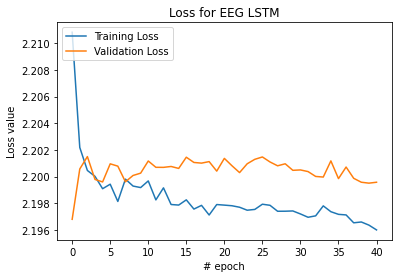

In [311]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss for EEG LSTM')
plt.ylabel('Loss value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

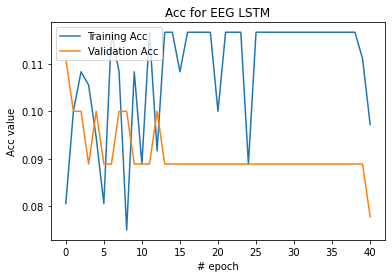

In [312]:
plt.plot(history.history['acc'], label='Training Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
plt.title('Acc for EEG LSTM')
plt.ylabel('Acc value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

In [248]:
model.load_weights(f"models\Best")

In [249]:
seconds_to_check = 1
seconds_per_recording = 15
interval_range = int(128 * seconds_to_check)
data_points = int(seconds_per_recording / seconds_to_check)

In [250]:
targets = range(0, 9)
total_train_x = []
total_train_y = []
for target in targets:
    df = trim_cols(load_df('second_checkerboard_recording_sultan_{}.csv'.format(target)))
    approx, decomp = filter_data(df)
    pca_approx = pca_and_inverse_with_load(approx) 
    pca_decomp = pca_and_inverse_with_load(decomp)
    total_data = np.concatenate((pca_approx, pca_decomp), axis=1)
#     total_data = pca_approx
#     total_data = pca_decomp
    train_x = split_to_training_data(total_data)
    train_x = scale_and_normalize(train_x)
    train_y = create_target_data(train_x, target)
    if target == targets[0]:
        total_train_x = train_x
        total_train_y = train_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_train_y = np.concatenate((total_train_y, train_y))

In [251]:
total_train_x.shape

(135, 10, 128)

In [252]:
model.evaluate(total_train_x, total_train_y, batch_size=128)

2/2 [==============================] - 0s 2ms/step - loss: 2.9524 - acc: 0.1111


[2.9523987770080566, 0.1111111119389534]

In [24]:
train_x.shape

(337, 12, 128)

In [34]:
pred = model.predict(train_x[0].reshape(-1, train_x.shape[1], train_x.shape[2]))

In [35]:
pred

array([[3.3189676e-04, 4.2085871e-03, 6.9821896e-03, 2.4181621e-03,
        2.3798265e-04, 2.1329962e-03, 5.0884534e-02, 6.4253420e-02,
        8.6855030e-01]], dtype=float32)

In [36]:
np.argmax(pred)

8

In [37]:
train_y[:10]

array([8, 7, 1, 2, 1, 1, 6, 1, 3, 7])

In [185]:
model.save_weights('models\model.h5')
model_json = model.to_json()
with open('models\model.json', "w") as json_file:
    json_file.write(model_json)